In [1]:
from google.colab import drive
drive.mount('/content/drive')

IMPLICIT_ZIP = "/content/drive/MyDrive/Colab Notebooks/implicit.zip"
EXPLICIT_ZIP = "/content/drive/MyDrive/Colab Notebooks/explicit_b.zip"
DATASET_ZIP  = "/content/drive/MyDrive/Colab Notebooks/dataset 3.zip"

!cp "$IMPLICIT_ZIP" .
!cp "$EXPLICIT_ZIP" .
!cp "$DATASET_ZIP" .

!unzip -q implicit.zip -d implicit_model
!unzip -q explicit_b.zip -d explicit_model
!unzip -q dataset\ 3.zip -d dataset3


Mounted at /content/drive


In [2]:
import os, json, random, math
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", DEVICE)


device: cpu


In [3]:
IMPLICIT_BASE_CANDIDATES = [
    "/content/implicit_model",
    "/content/implicit"
]

EXPLICIT_BASE_CANDIDATES = [
    "/content/explicit_model",
    "/content/explicit_b"
]

def find_model_dir(base_dir):
    if not os.path.exists(base_dir):
        return None
    for root, dirs, files in os.walk(base_dir):
        if "config.json" in files and (
            "pytorch_model.bin" in files or "model.safetensors" in files
        ):
            return root
    return None

def pick_first_exist(candidates):
    for c in candidates:
        d = find_model_dir(c)
        if d is not None:
            print(" -> found checkpoint under:", d)
            return d
    raise FileNotFoundError("checkpoint not found")

implicit_dir = pick_first_exist(IMPLICIT_BASE_CANDIDATES)
explicit_dir = pick_first_exist(EXPLICIT_BASE_CANDIDATES)


 -> found checkpoint under: /content/implicit_model/implicit
 -> found checkpoint under: /content/explicit_model/explicit_b


In [4]:
def load_finetuned_model(path):
    tokenizer = AutoTokenizer.from_pretrained(path)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    model = AutoModelForCausalLM.from_pretrained(path)
    model.to(DEVICE)
    model.eval()
    return model, tokenizer

implicit_model, implicit_tok = load_finetuned_model(implicit_dir)
explicit_model, explicit_tok = load_finetuned_model(explicit_dir)


In [5]:
DATASET_DIR = "/content/dataset3/dataset 3"
TRAIN_PATH = os.path.join(DATASET_DIR, "train_arla_implicit.jsonl")
TEST_PATH  = os.path.join(DATASET_DIR, "test_arla.jsonl")

def load_jsonl(path):
    data = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line=line.strip()
            if line:
                data.append(json.loads(line))
    return data

raw_train = load_jsonl(TRAIN_PATH)
raw_test  = load_jsonl(TEST_PATH)

print("train:", len(raw_train), "test:", len(raw_test))


###############
# Normalize
###############
def map_label(raw):
    l = str(raw).lower().strip()
    GOOD = ["ok","acceptable","correct","grammatical","good","g","1","yes","true"]
    BAD  = ["violation","ungrammatical","incorrect","bad","u","0","no","false"]
    if l in GOOD:
        return "good"
    if l in BAD:
        return "bad"
    return l

def normalize_dataset(raw_list):
    out=[]
    for obj in raw_list:
        sent = obj["text"]
        label = map_label(obj["label"])
        out.append({"sentence": sent, "label": label})
    return out

train_data = normalize_dataset(raw_train)
test_data  = normalize_dataset(raw_test)
test_data = test_data[:50]   # test 50개만 사용

print(train_data[0])


train: 38400 test: 4800
{'sentence': 'pleck troise li droz vode neimo pelio pelio troiso troiso lu vogo', 'label': 'bad'}


In [6]:
NATURAL_LABELS = {
    "good": "The sentence is grammatical.",
    "bad":  "The sentence is ungrammatical."
}

CANDIDATE_LABEL_TEXTS = list(NATURAL_LABELS.values())


In [7]:
def build_instruction_prompt(query_ex, support_exs):
    prompt = ""

    # Support examples
    for ex in support_exs:
        label_text = NATURAL_LABELS[ex["label"]]
        prompt += f"Sentence: {ex['sentence']}\n"
        prompt += f"Explanation: {label_text}\n\n"

    # Query
    prompt += f"Sentence: {query_ex['sentence']}\n"
    prompt += "Explanation: "
    return prompt


In [8]:
@torch.no_grad()
def continuation_logprob(model, tokenizer, prompt, continuation, normalize=False):
    enc_prompt = tokenizer(prompt, return_tensors="pt").to(DEVICE)
    enc_cont   = tokenizer(continuation, return_tensors="pt", add_special_tokens=False).to(DEVICE)

    input_ids = torch.cat([enc_prompt.input_ids, enc_cont.input_ids], dim=1)
    attn = torch.ones_like(input_ids)

    out = model(input_ids=input_ids, attention_mask=attn)
    logits = out.logits

    log_probs = torch.log_softmax(logits[:, :-1, :], dim=-1)
    target = input_ids[:, 1:]
    selected = log_probs.gather(2, target.unsqueeze(-1)).squeeze(-1)

    cont_len = enc_cont.input_ids.shape[1]
    cont_lp = selected[0, -cont_len:]

    if normalize:
        return cont_lp.mean().item()
    else:
        return cont_lp.sum().item()


In [9]:
@torch.no_grad()
def unconditional_logprob(model, tokenizer, continuation):
    enc = tokenizer(continuation, return_tensors="pt", add_special_tokens=True).to(DEVICE)

    out = model(**enc)
    logits = out.logits

    log_probs = torch.log_softmax(logits[:, :-1, :], dim=-1)
    target = enc.input_ids[:, 1:]
    selected = log_probs.gather(2, target.unsqueeze(-1)).squeeze(-1)

    return selected.sum().item()


In [10]:
def pmi_score(model, tokenizer, prompt, label_text, normalize=False):
    lp_cond = continuation_logprob(model, tokenizer, prompt, label_text, normalize)
    lp_prior = unconditional_logprob(model, tokenizer, label_text)
    return lp_cond - lp_prior


In [11]:
def predict_label_pmi(model, tokenizer, prompt,
                      labels=CANDIDATE_LABEL_TEXTS, normalize=True):

    scores = {}
    for label_text in labels:
        score = pmi_score(model, tokenizer, prompt, label_text, normalize)
        scores[label_text] = score

    best = max(scores, key=scores.get)

    # 자연어 label → good/bad 역매핑
    for key, val in NATURAL_LABELS.items():
        if val == best:
            return key, scores

    return None, scores


In [12]:
def create_balanced_support_set(train_data, n_shots, seed=42):
    random.seed(seed)
    by_label = {"good": [], "bad": []}

    for ex in train_data:
        by_label[ex["label"]].append(ex)

    support = []
    per = n_shots // 2
    rem = n_shots % 2

    for i,label in enumerate(["good","bad"]):
        k = per + (1 if i<rem else 0)
        sample = random.sample(by_label[label], min(k, len(by_label[label])))
        support.extend(sample)

    random.shuffle(support)
    return support


In [16]:
def run_icl_pmi(
    model, tokenizer,
    train_data, test_data,
    n_shots_list=[0,2,4,8],
    normalize=True,
    seed=42
):
    results = {}

    for n in n_shots_list:
        if n > 0:
            fixed_support = create_balanced_support_set(train_data, n, seed)

        correct = 0
        total = 0

        for ex in test_data:
            support = fixed_support if n > 0 else []
            prompt = build_instruction_prompt(ex, support)

            pred, scores = predict_label_pmi(
                model, tokenizer,
                prompt,
                normalize=normalize
            )

            if pred == ex["label"]:
                correct += 1

            total += 1

        acc = correct / total
        print(f"[n={n}] accuracy = {acc:.4f}")
        results[n] = acc

    return results


In [18]:
def load_model_base(name="gpt2"):
    tok = AutoTokenizer.from_pretrained(name)
    if tok.pad_token is None:
        tok.pad_token = tok.eos_token
    model = AutoModelForCausalLM.from_pretrained(name)
    model.to(DEVICE)
    model.eval()
    return model, tok

gpt_base, gpt_tok = load_model_base("gpt2")


In [19]:
shots = [0,1,2,4]

results = {
    "GPT2-Base": {},
    "ArLa-Explicit": {},
    "ArLa-Implicit": {}
}

# GPT2-Base
for s in shots:
    results["GPT2-Base"][s] = run_icl_pmi(
        gpt_base, gpt_tok,
        train_data, test_data,
        n_shots_list=[s]
    )[s]

# Explicit
for s in shots:
    results["ArLa-Explicit"][s] = run_icl_pmi(
        explicit_model, explicit_tok,
        train_data, test_data,
        n_shots_list=[s]
    )[s]

# Implicit
for s in shots:
    results["ArLa-Implicit"][s] = run_icl_pmi(
        implicit_model, implicit_tok,
        train_data, test_data,
        n_shots_list=[s]
    )[s]


[n=0] accuracy = 0.4000
[n=1] accuracy = 0.4000
[n=2] accuracy = 0.4000
[n=4] accuracy = 0.4000
[n=0] accuracy = 0.4000
[n=1] accuracy = 0.4000
[n=2] accuracy = 0.4000
[n=4] accuracy = 0.4000
[n=0] accuracy = 0.6000
[n=1] accuracy = 0.6000
[n=2] accuracy = 0.6000
[n=4] accuracy = 0.6000


In [20]:
import pandas as pd

df = pd.DataFrame(results).T
df = df[shots]
df.columns = ["0-shot","1-shot","2-shot","4-shot"]
df


,0-shot,1-shot,2-shot,4-shot
GPT2-Base,0.4,0.4,0.4,0.4
ArLa-Explicit,0.4,0.4,0.4,0.4
ArLa-Implicit,0.6,0.6,0.6,0.6


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48169 (\N{HANGUL SYLLABLE BANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49885 (\N{HANGUL SYLLABLE SIG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


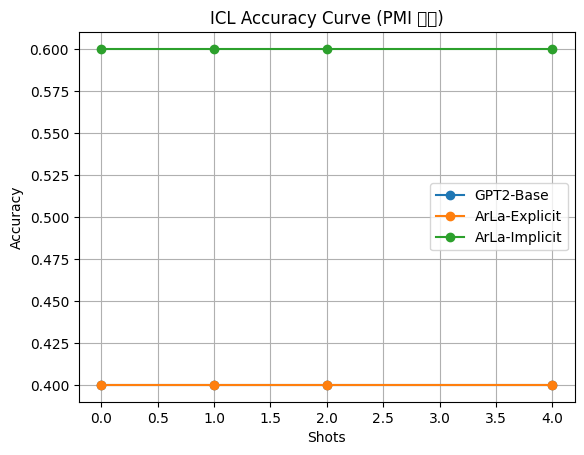

In [21]:
import matplotlib.pyplot as plt

for model_name in results:
    ys = [results[model_name][s] for s in shots]
    plt.plot(shots, ys, marker='o', label=model_name)

plt.xlabel("Shots")
plt.ylabel("Accuracy")
plt.title("ICL Accuracy Curve (PMI 방식)")
plt.grid(True)
plt.legend()
plt.show()
